In [1]:
import os
import numpy as np
import mne

mne.set_log_level("error")

import torch
import torch.nn as nn
from torch import no_grad
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
#@title Config
MAPPING = {7: "feet", 8: "left_hand", 9: "right_hand", 10: "tongue"}

batch_size = 48
cfg = dict(
    preprocessing=dict(
        target_freq=100,
        low_freq=8,
        high_freq=25,
        average_ref=True,
        normalize = True
    ),
    epochs=dict(
        baseline=(-0.1, 1.9),
        tmin=-0.1,
        tmax=5.9,
    )
)

In [23]:
#@title Dataset

class MI_Dataset(Dataset):
    def __init__(self, subject_id, runs, signals=None, device="cpu", config="default", verbose=False):
        self.subject_id = subject_id
        self.device = device
        self.runs = runs
        self.signals = signals if signals is not None else list(MAPPING.values())

        self.load_config()
        self.load_raw()
        self.apply_preprocess()
        self.create_epochs()
        if verbose:
            print(self.epochs)

        self.split_by_runs()
        self.format_data()

        self.time_steps = self.X.shape[-1]
        self.channels = self.X.shape[-2]
        
        if verbose:
            print("#" * 50)
            print("Dataset created:")
            print(f"X --> {self.X.shape} ({self.X.dtype})")
            print(f"y --> {self.y.shape} ({self.y.dtype})")
            print("#" * 50)

    def load_config(self):

        self.target_freq = cfg["preprocessing"]["target_freq"]
        self.low_freq = cfg["preprocessing"]["low_freq"]
        self.high_freq = cfg["preprocessing"]["high_freq"]
        self.average_ref = cfg["preprocessing"]["average_ref"]

        self.baseline = cfg["epochs"]["baseline"]
        self.tmin = cfg["epochs"]["tmin"]
        self.tmax = cfg["epochs"]["tmax"]

        self.normalize = cfg["preprocessing"]["normalize"]

    def load_raw(self):
        subject_path =  "A0" + str(self.subject_id) + "T.gdf"
        self.raw = mne.io.read_raw_gdf(subject_path, preload=True)

        channels_to_keep = ["EEG-Cz", "EEG-C4", "EEG-C3"]
        self.raw.pick_channels(channels_to_keep)


        self.filter_events()

    def filter_events(self):
        events, _ = mne.events_from_annotations(self.raw)
        event_ids = {k: v for k, v in MAPPING.items() if v in self.signals}
        annot_from_events = mne.annotations_from_events(
            events, event_desc=event_ids, sfreq=self.raw.info["sfreq"]
        )

        self.raw.set_annotations(annot_from_events)

    def apply_preprocess(self):
        self.raw = self.raw.resample(self.target_freq, npad="auto")
        if self.average_ref:
            self.raw = self.raw.set_eeg_reference("average", projection=True)

        self.raw = self.raw.filter(l_freq=self.low_freq, h_freq=self.high_freq)

    def create_epochs(self):
        events, event_ids = mne.events_from_annotations(self.raw)
        self.epochs = mne.Epochs(
            self.raw,
            events=events,
            event_id=event_ids,
            tmin=self.tmin,
            tmax=self.tmax,
            baseline=self.baseline,
            preload=True,
        )
        self.epochs = self.epochs.crop(tmin=self.baseline[-1], tmax=self.tmax)
        self.epochs.plot()
        del self.raw

    def split_by_runs(self):
        X = self.epochs.get_data()

        if self.normalize:
            orig_shape = X.shape
            X = X.reshape(X.shape[0], -1)
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
            X = X.reshape(orig_shape)
            y = self.epochs.events[:, -1]
        y -= 1  # start at 0

        X_by_runs = []
        y_by_runs = []

        for index in range(0, int(X.shape[0] // 48)):
            X_by_runs.append(X[index * 48 : (index + 1) * 48])
            y_by_runs.append(y[index * 48 : (index + 1) * 48])

        self.runs_features = np.array(X_by_runs)
        self.runs_labels = np.array(y_by_runs)

        # Determine the maximum number of valid runs
        max_run_index = len(self.runs_features) - 1

        # Update the runs based on available data
        self.runs = [run for run in self.runs if run <= max_run_index]

        if not self.runs:
            raise ValueError("No valid runs available after filtering.")

        self.runs_features = self.runs_features[self.runs]
        self.runs_labels = self.runs_labels[self.runs]

        self.X = self.runs_features.reshape(
            -1, self.runs_features.shape[2], self.runs_features.shape[3]
        )
        self.y = self.runs_labels.reshape(-1)

    

    def format_data(self):
        self.X = torch.from_numpy(self.X).float()
        self.y = torch.from_numpy(self.y).long()

        self.X = self.X.to(self.device)
        self.y = self.y.to(self.device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [3]:
#@title Dataset

class MI_Dataset_ALL(Dataset):
    def __init__(self, data_folder="data", subject_ids=list(range(1, 10)), signals=None, device="cpu", config="default", verbose=False):
        self.data_root = data_folder
        self.subject_ids = subject_ids
        self.device = device

        self.signals = signals if signals is not None else list(MAPPING.values())  # Include all signals by default

        self.load_config()
        self.load_raw()
        self.apply_preprocess()
        self.create_epochs()
        if verbose:
            print(self.epochs)

        self.format_data()

        self.time_steps = self.X.shape[-1]
        self.channels = self.X.shape[-2]
        
        if verbose:
            print("#" * 50)
            print("Dataset created:")
            print(f"X --> {self.X.shape} ({self.X.dtype})")
            print(f"y --> {self.y.shape} ({self.y.dtype})")
            print("#" * 50)

    def load_config(self) -> None:

        self.target_freq = cfg["preprocessing"]["target_freq"]
        self.low_freq = cfg["preprocessing"]["low_freq"]
        self.high_freq = cfg["preprocessing"]["high_freq"]
        self.average_ref = cfg["preprocessing"]["average_ref"]

        self.baseline = cfg["epochs"]["baseline"]
        self.tmin = cfg["epochs"]["tmin"]
        self.tmax = cfg["epochs"]["tmax"]

        self.normalize = cfg["preprocessing"]["normalize"]

    def load_raw(self) -> None:
        self.subject_paths = [
            os.path.join(self.data_root, "A0" + str(subject_id) + "T.gdf")
            for subject_id in self.subject_ids
        ]
        
        self.raws = [
            mne.io.read_raw_gdf(subject_path, preload=True)
            for subject_path in self.subject_paths
        ]

        # Keep only desired channels
        channels_to_keep = ["EEG-Cz", "EEG-C4", "EEG-C3"]
        # self.raw.pick_channels(channels_to_keep)
        for raw in self.raws:
            raw.pick_channels(channels_to_keep)

        self.filter_events()

    def filter_events(self) -> None:
        for raw in self.raws:
            events, _ = mne.events_from_annotations(raw)
            event_ids = {k: v for k, v in MAPPING.items() if v in self.signals}  # Filter the event_ids by signals
            annot_from_events = mne.annotations_from_events(
                events, event_desc=event_ids, sfreq=raw.info["sfreq"]
            )

            raw.set_annotations(annot_from_events)

    def apply_preprocess(self) -> None:
        def preprocess_raw(session):
            session = session.resample(self.target_freq, npad="auto")
            if self.average_ref:
                session = session.set_eeg_reference("average", projection=True)
            session = session.filter(l_freq=self.low_freq, h_freq=self.high_freq)
            return session

        self.raws = [preprocess_raw(raw) for raw in self.raws]

    def create_epochs(self):
        def split2epochs(session):
            events, event_ids = mne.events_from_annotations(session)
            return mne.Epochs(
                session,
                events=events,
                event_id=event_ids,
                tmin=self.tmin,
                tmax=self.tmax,
                baseline=self.baseline,
                preload=True,
            )

        self.epochs = [split2epochs(raw) for raw in self.raws]
        self.epochs = mne.concatenate_epochs(self.epochs)
        self.epochs = self.epochs.crop(tmin=self.baseline[-1], tmax=self.tmax)
        #self.epochs.plot()
        del self.raws

    def format_data(self):
        self.X = self.epochs.get_data()

        self.y = self.epochs.events[:, -1]
        self.y -= 1  # start at 0

        if self.normalize:
            self.do_normalize()
        self.X = torch.from_numpy(self.X).float()
        self.y = torch.from_numpy(self.y).long()

        self.X = self.X.to(self.device)
        self.y = self.y.to(self.device)

    def do_normalize(self):
        orig_shape = self.X.shape
        self.X = self.X.reshape(self.X.shape[0], -1)
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        self.X = self.X.reshape(orig_shape)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [4]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
subject_ids = [1,2,4,5,6,7,8,9]


train_dataset = MI_Dataset_ALL("data", subject_ids, signals=["feet"], device = device, verbose = True)
train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, drop_last=True)

<EpochsArray |  576 events (all good), 1.9 – 5.9 s, baseline -0.1 – 1.9 s (baseline period was cropped after baseline correction), ~5.3 MB, data loaded,
 'feet': 576>
##################################################
Dataset created:
X --> torch.Size([576, 3, 401]) (torch.float32)
y --> torch.Size([576]) (torch.int64)
##################################################


In [14]:
subject = 1
train_runs = [0,1,2,3,4]
test_runs = [5]


train_dataset = MI_Dataset(subject, train_runs, device = device, verbose = True)
test_dataset = MI_Dataset(subject, test_runs, device = device, verbose = True)

train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=True)

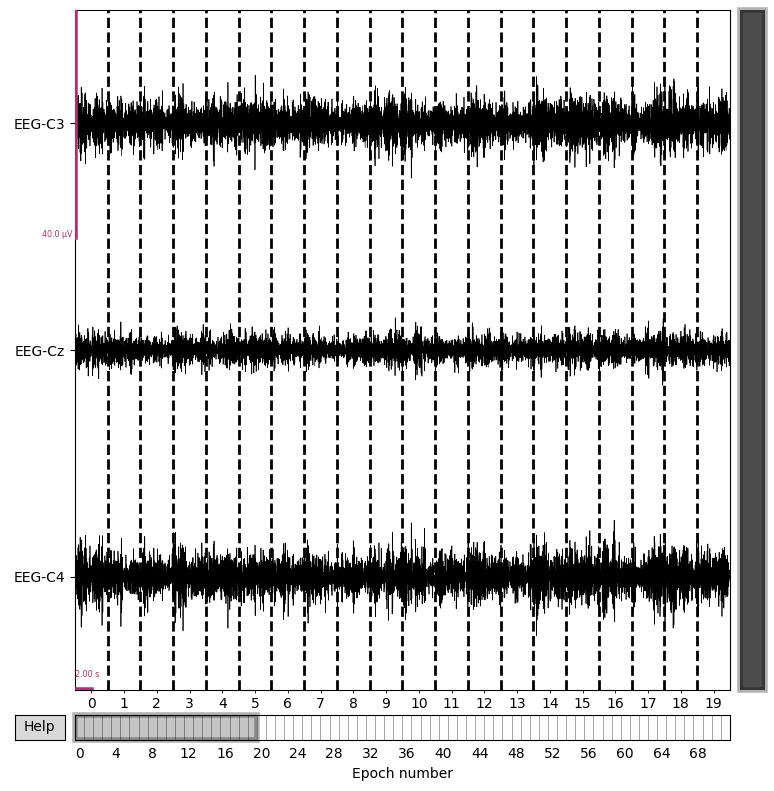

<Epochs |  72 events (all good), 1.9 – 5.9 s, baseline -0.1 – 1.9 s (baseline period was cropped after baseline correction), ~686 kB, data loaded,
 'right_hand': 72>
##################################################
Dataset created:
X --> torch.Size([48, 3, 401]) (torch.float32)
y --> torch.Size([48]) (torch.int64)
##################################################


In [24]:
subject = 1
train_runs = [0,1,2,3,4,5]


train_dataset = MI_Dataset(subject, train_runs, signals=['right_hand'], device = device, verbose = True)
train_dataloader = DataLoader(train_dataset,  batch_size=24, shuffle=True, drop_last=True)

In [8]:
print(f"Train dataset: {len(train_dataset)} samples")
# print(f"Test dataset: {len(test_dataset)} samples")
i = 0

for features, label in train_dataloader:
    print(features.shape)
    print(label)
    break

Train dataset: 576 samples
torch.Size([48, 3, 401])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [31]:
subject_path =  "A0" + str(1) + "T.gdf"
raw = mne.io.read_raw_gdf(subject_path, preload=True)
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
>

In [6]:
from utils import gradient_penalty

In [7]:
import torch
from torch import nn

# Define the custom LeakyReLU activation function
lrelu = nn.LeakyReLU(0.2)

class PixelNorm1D(nn.Module):
    def __init__(self):
        super(PixelNorm1D, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.lrelu = lrelu
        self.pixel_norm = PixelNorm1D()
        self.scale_factor = scale_factor

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor)  # Upsample
        x = self.lrelu(self.pixel_norm(self.conv1(x)))
        x = self.lrelu(self.pixel_norm(self.conv2(x)))
        return x

    # def forward(self, x):
    #     x = nn.functional.interpolate(x, scale_factor=2)  # Upsample
    #     x = self.lrelu(self.pixel_norm(self.conv1(x)))
    #     x = self.lrelu(self.pixel_norm(self.conv2(x)))
    #     return x

class EEG_GAN_Generator(nn.Module):
    def __init__(self, latent_dim):
        super(EEG_GAN_Generator, self).__init__()
        self.latent_dim = latent_dim
        self.linear = nn.Linear(latent_dim, 50*7) # Adjusted for 401 input
        self.main = nn.Sequential(
            UpsampleBlock(50, 50),
            UpsampleBlock(50, 50),
            UpsampleBlock(50, 50),
            UpsampleBlock(50, 50),
            UpsampleBlock(50, 50),
            UpsampleBlock(50, 50, scale_factor=1.791), # 1.79017857 1.4375
            nn.Conv1d(50, 3, kernel_size=1) # Changed the input channels to 3
        )

    def forward(self, z):
        z = z.view(-1, self.latent_dim)
        z = self.linear(z)
        z = z.view(-1, 50, 7) # Adjusted for 401
        return self.main(z)
    
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9):
        super(DownsampleBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.lrelu = lrelu
        self.avg_pool = nn.AvgPool1d(2)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.avg_pool(x)
        return x

class EEG_GAN_Discriminator(nn.Module):
    def __init__(self):
        super(EEG_GAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(3, 50, kernel_size=1), # Changed the input channels to 3
            DownsampleBlock(50, 50),
            DownsampleBlock(50, 50),
            DownsampleBlock(50, 50),
            DownsampleBlock(50, 50),
            DownsampleBlock(50, 50),
            nn.Flatten(),
            #nn.Linear(50*13, 1) # Adjusted for 401 input
            nn.Linear(50*12, 1)
        )

    def forward(self, x):
        return self.main(x)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import gradient_penalty, save_checkpoint, load_checkpoint

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
BATCH_SIZE = 48
CHANNELS_SIGNALS = 3 # 3 if cz, c4 and c3
Z_DIM = 200
NUM_EPOCHS = 100
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [9]:
gen = EEG_GAN_Generator(Z_DIM).to(device)
critic = EEG_GAN_Discriminator().to(device)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))

fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1).to(device)
writer_real = SummaryWriter(f"logs/EEG/real")
writer_fake = SummaryWriter(f"logs/EEG/fake")
step = 0

gen.train()
critic.train()

EEG_GAN_Discriminator(
  (main): Sequential(
    (0): Conv1d(3, 50, kernel_size=(1,), stride=(1,))
    (1): DownsampleBlock(
      (conv1): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
      (lrelu): LeakyReLU(negative_slope=0.2)
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): DownsampleBlock(
      (conv1): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
      (lrelu): LeakyReLU(negative_slope=0.2)
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (3): DownsampleBlock(
      (conv1): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
      (lrelu): LeakyReLU(negative_slope=0.2)
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
 

In [10]:
start_epoch = 0 # 0 if training from scratch
# start_epoch = load_checkpoint(gen, opt_gen, "generator_checkpoint.pth")
# start_epoch = max(start_epoch, load_checkpoint(critic, opt_critic, "critic_checkpoint.pth"))

In [13]:
for epoch in range(start_epoch, NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(train_dataloader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)

            gp = gradient_penalty(critic, real, fake, device=device)
            w_dist = torch.mean(critic_real) - torch.mean(critic_fake)
            # Update the critic loss function
            loss_critic = -w_dist + torch.max(w_dist, torch.zeros_like(w_dist)) * LAMBDA_GP * gp
            
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 10 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)

                if CHANNELS_SIGNALS > 1:
                    fig, axs = plt.subplots(CHANNELS_SIGNALS*2)
                    fig.suptitle('Real and Fake EEG signals')
                    for i in range(CHANNELS_SIGNALS):
                        axs[i].plot(real[0, i, :].cpu().numpy())
                        axs[i].set_title(f"Real Channel {i+1}")
                        axs[i+CHANNELS_SIGNALS].plot(fake[0, i, :].cpu().numpy())
                        axs[i+CHANNELS_SIGNALS].set_title(f"Fake Channel {i+1}")
                else:
                    fig, axs = plt.subplots(2)
                    fig.suptitle('Real and Fake EEG signals')
                    axs[0].plot(real[0].cpu().numpy())
                    axs[0].set_title("Real")
                    axs[1].plot(fake[0].cpu().numpy())
                    axs[1].set_title("Fake")

                writer_real.add_figure("EEG signals", fig, global_step=step)

            step += 1
        
        if epoch == 0:
            save_checkpoint(epoch, gen, opt_gen, "generator_checkpoint.pth")
            save_checkpoint(epoch, critic, opt_critic, "critic_checkpoint.pth")

  8%|▊         | 1/12 [00:12<02:15, 12.36s/it]

=> Saving checkpoint
=> Saving checkpoint


  8%|▊         | 1/12 [00:14<02:39, 14.50s/it]


KeyboardInterrupt: 